In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

In [192]:
# Membaca dan melihat data CSV

df_ecommerce_customer_churn = pd.read_csv('data_ecommerce_customer_churn.csv')
df_ecommerce_customer_churn.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [193]:
# Memahami data menggunakan .info() untuk melihat tipe data setiap kolom
# Melihat apakah ada kolom yang tidak sesuai tipe datanya

df_ecommerce_customer_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


In [194]:
# Melihat apakah ada data Null, Duplicate atau N/A

print(f'Cek apakah ada data yang Null: \n{df_ecommerce_customer_churn.isnull().sum()}\n')
print(f'Cek apakah ada data yang duplicate: \n{df_ecommerce_customer_churn.duplicated().sum()}\n')
print(f'Cek apakah ada data yang N/A: \n{df_ecommerce_customer_churn.isna().sum()}\n')

Cek apakah ada data yang Null: 
Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64

Cek apakah ada data yang duplicate: 
671

Cek apakah ada data yang N/A: 
Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64



In [195]:
unique_data = df_ecommerce_customer_churn.nunique()
print(unique_data)

Tenure                        36
WarehouseToHome               33
NumberOfDeviceRegistered       6
PreferedOrderCat               6
SatisfactionScore              5
MaritalStatus                  3
NumberOfAddress               14
Complain                       2
DaySinceLastOrder             22
CashbackAmount              2335
Churn                          2
dtype: int64


In [196]:
X = df_ecommerce_customer_churn.drop(columns=['Churn'])
y = df_ecommerce_customer_churn['Churn']

In [197]:
numeric_features = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount']
categorical_features = ['PreferedOrderCat', 'MaritalStatus']

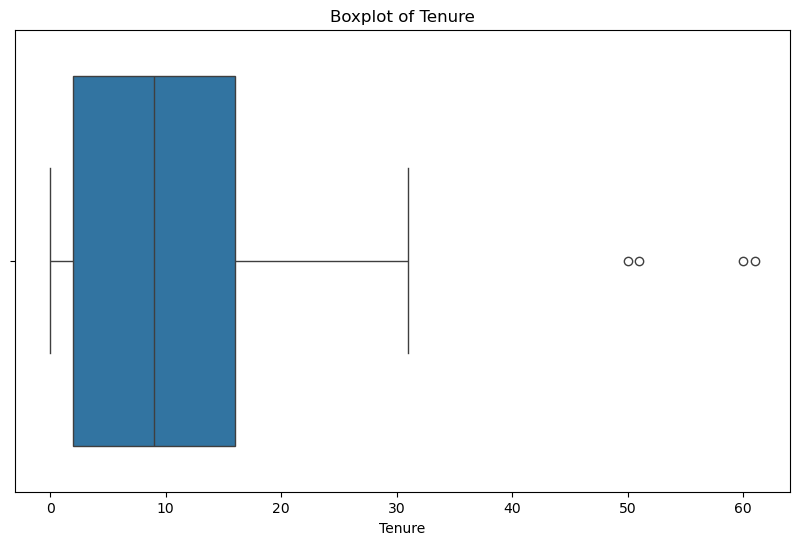

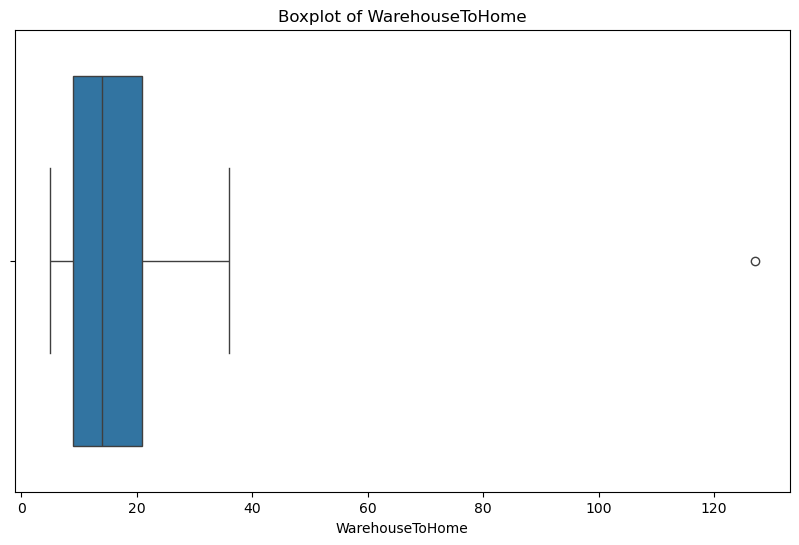

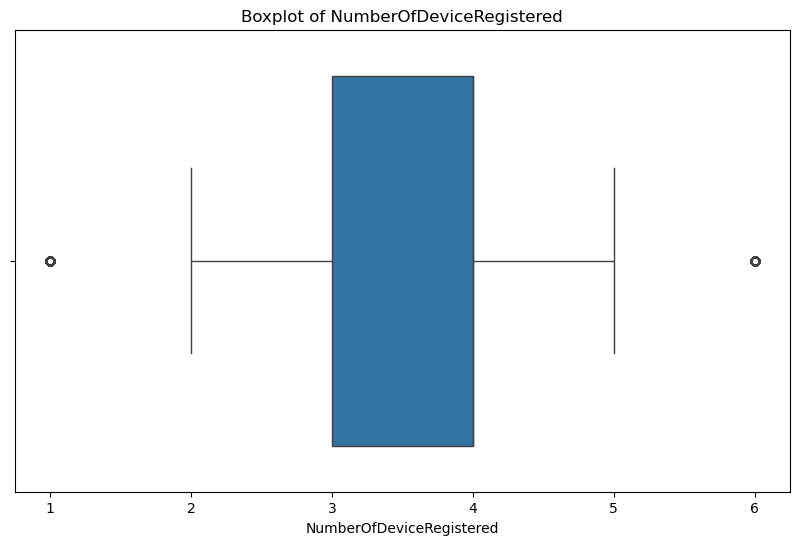

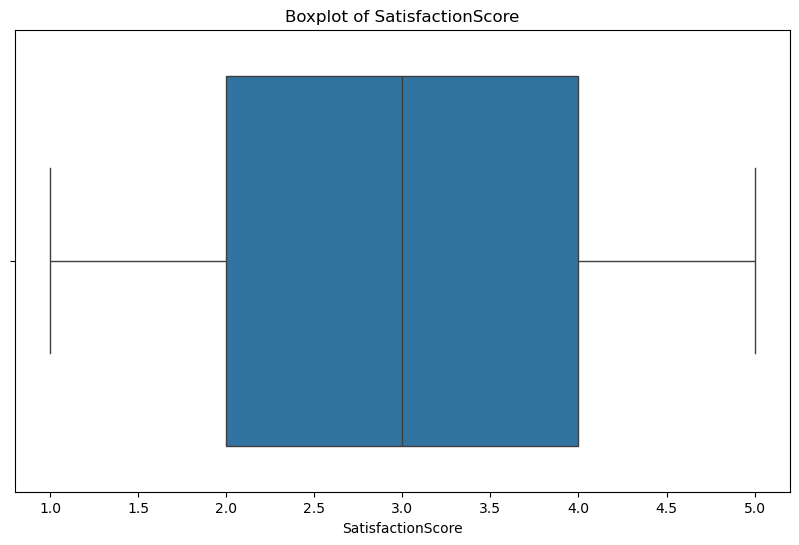

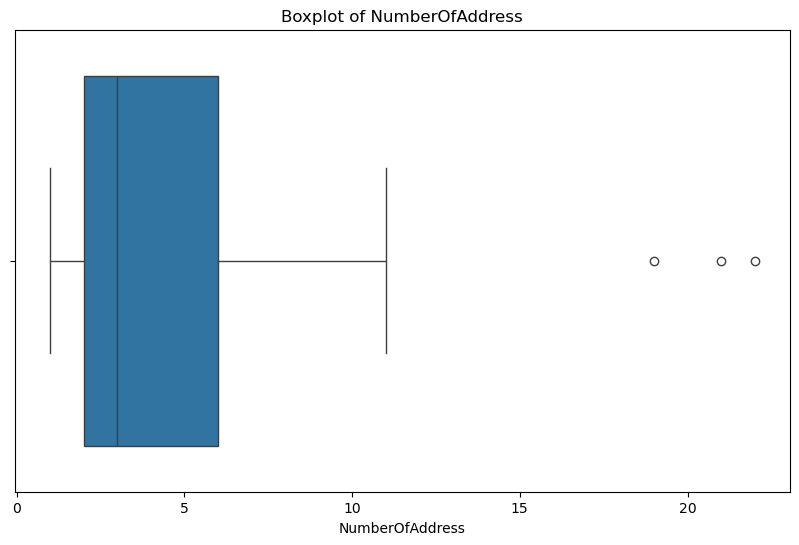

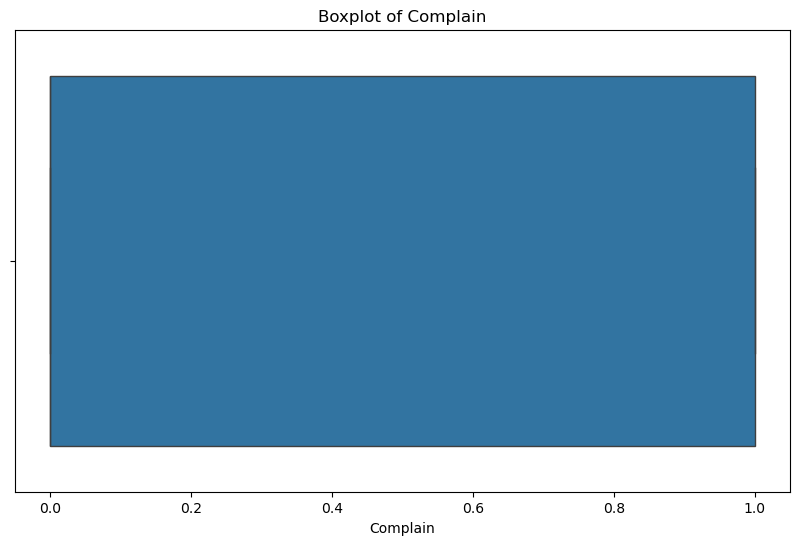

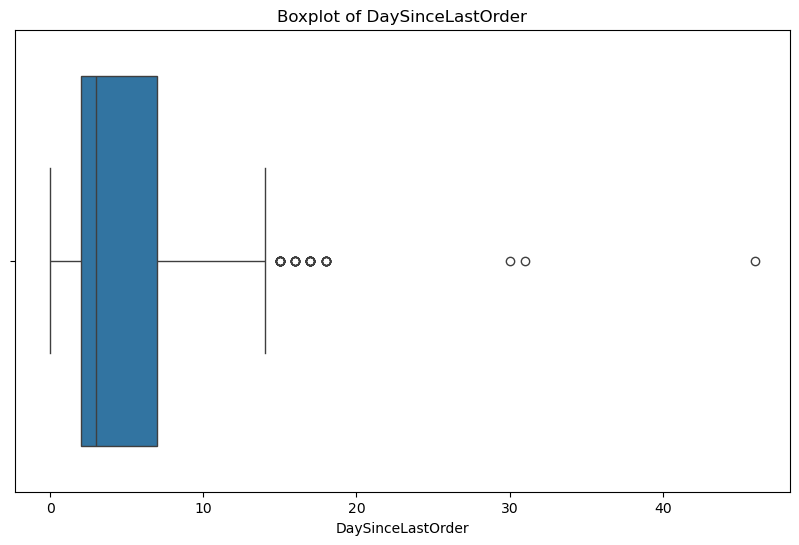

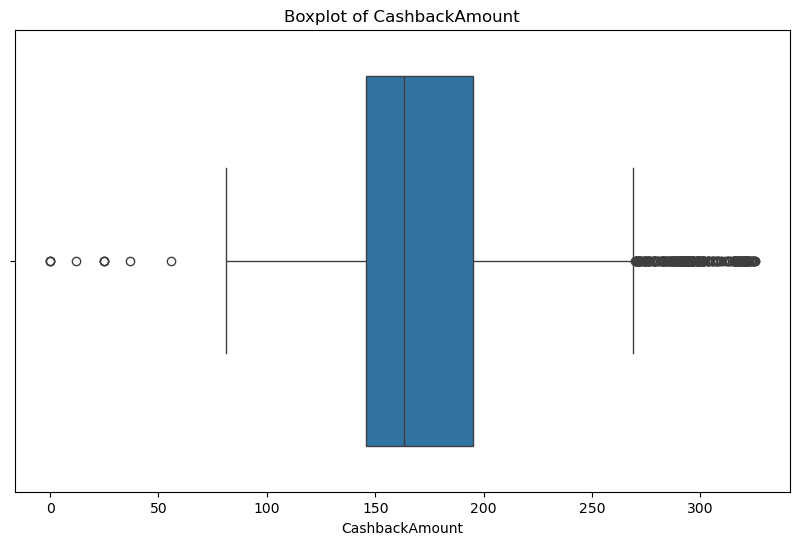

In [198]:
# Plot boxplot for all numeric columns to see outliers
for column in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_ecommerce_customer_churn[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

In [199]:
# numeric_feature

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [200]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False))
])

In [201]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_features', numeric_transformer, numeric_features),
        ('categorical_features', categorical_transformer, categorical_features)
    ]
)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

In [203]:
# 4. Define Models and Hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(solver='liblinear'),
        'params': {
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l1', 'l2'],
            'model__class_weight': [None, 'balanced']
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7, 9],
            'model__weights': ['uniform', 'distance'],
            'model__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'model__max_depth': [3, 5, 10, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__criterion': ['gini', 'entropy'],
            'model__class_weight': [None, 'balanced']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 10, None]
        }
    }
}

In [204]:
# 5. Train and Evaluate Models without Hyperparameter Tuning
for model_name, config in models.items():
    print(f"\nTraining without Tuning: {model_name}")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', config['model'])
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['model'], 'predict_proba') else None

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    pr_score = average_precision_score(y_test, y_prob) if y_prob is not None else 'N/A'

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc}")
    print(f"PR Score: {pr_score}")



Training without Tuning: Logistic Regression
Accuracy: 0.8745
Recall: 0.4963
Precision: 0.6837
F1 Score: 0.5751
ROC AUC: 0.8738588741646846
PR Score: 0.6567565439901746

Training without Tuning: K-Nearest Neighbors
Accuracy: 0.8758
Recall: 0.4222
Precision: 0.7403
F1 Score: 0.5377
ROC AUC: 0.8848284063880394
PR Score: 0.6190169282292567

Training without Tuning: Decision Tree
Accuracy: 0.9303
Recall: 0.7481
Precision: 0.8279
F1 Score: 0.7860
ROC AUC: 0.8580190282025143
PR Score: 0.6624610710567203

Training without Tuning: Random Forest
Accuracy: 0.9379
Recall: 0.7481
Precision: 0.8707
F1 Score: 0.8048
ROC AUC: 0.9495639370257107
PR Score: 0.8856868986373625


In [205]:
# 6. Train and Evaluate Models with Hyperparameter Tuning
for model_name, config in models.items():
    print(f"\nTraining and Tuning: {model_name}")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', config['model'])
    ])
    
    grid_search = GridSearchCV(pipeline, config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters for {model_name}:")
    print(grid_search.best_params_)

    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search.best_estimator_.named_steps['model'], 'predict_proba') else None

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    pr_score = average_precision_score(y_test, y_prob) if y_prob is not None else 'N/A'

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc}")
    print(f"PR Score: {pr_score}")



Training and Tuning: Logistic Regression
Best Parameters for Logistic Regression:
{'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2'}
Accuracy: 0.8758
Recall: 0.4593
Precision: 0.7126
F1 Score: 0.5586
ROC AUC: 0.8710159700985389
PR Score: 0.6512227460575597

Training and Tuning: K-Nearest Neighbors
Best Parameters for K-Nearest Neighbors:
{'model__n_neighbors': 9, 'model__p': 1, 'model__weights': 'distance'}
Accuracy: 0.9151
Recall: 0.6000
Precision: 0.8617
F1 Score: 0.7074
ROC AUC: 0.9243628950050968
PR Score: 0.8164559323525

Training and Tuning: Decision Tree
Best Parameters for Decision Tree:
{'model__class_weight': 'balanced', 'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Accuracy: 0.9303
Recall: 0.7481
Precision: 0.8279
F1 Score: 0.7860
ROC AUC: 0.8580190282025143
PR Score: 0.6624610710567203

Training and Tuning: Random Forest
Best Parameters for Random Forest:
{'model__max_depth': None, 'mo